## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


### Work flows
#### Parrish
https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469

#### Graph convolutional network ("semi-supervised")
https://towardsdatascience.com/text-based-graph-convolutional-network-for-semi-supervised-bible-book-classification-c71f6f61ff0f

In [1]:
url = 'https://www.gutenberg.org/ebooks/4217'

import copy
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #For viewing 3d pca feature plots
import seaborn as sns

from sklearn.decomposition import PCA #For squashing word vector means
from sklearn.preprocessing import StandardScaler #For normalizing data
#To divide data when testing a trained model
from sklearn.model_selection import train_test_split 
#To build regular logistic regression models
from sklearn.linear_model import LogisticRegression
# ENSEMBLE METHODS:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


##################
# ASSESSING MODELS:
#To assess accuracy of logistic regression or decision trees
from sklearn.metrics import confusion_matrix 
#To iteratively append labels to cells in a confusion matrix
import itertools 
#To get accuracy, precision, recall, and F1 score (weighted accuracy) of a given confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#To view the accuracy metrics for a given confusion matrix
from sklearn.metrics import classification_report

#Learn workflow
from nltk.corpus import stopwords
import string #for removing punctuation from text
from nltk import word_tokenize #Another way of tokenizing
from nltk import FreqDist

from pandasql import sqldf #for manipulating DataFrames with SQL style queries

#Parrish workflow
from numpy import dot #parrish
from numpy.linalg import norm #parrish
import en_core_web_md #parrish
import spacy #parrish 
from __future__ import unicode_literals #parrish

# Learn.co workflow 

In [ ]:
#Needed for first time use on each machine:
#import nltk
#nltk.download('stopwords')

In [ ]:
#Read files (without nlp module)
with open('chapter1.txt', 'r', encoding = 'utf-8') as f1, \
    open('chapter2.txt', 'r', encoding = 'utf-8') as f2, \
    open('chapter3.txt', 'r', encoding = 'utf-8') as f3, \
    open('chapter4.txt', 'r', encoding = 'utf-8') as f4, \
    open('chapter5.txt', 'r', encoding = 'utf-8') as f5:
    ch1 = f1.read()
    ch2 = f2.read()
    ch3 = f3.read()
    ch4 = f4.read()
    ch5 = f5.read()

In [ ]:
#tokenize all
tokens1 = word_tokenize(ch1)
tokens2 = word_tokenize(ch2)
tokens3 = word_tokenize(ch3)
tokens4 = word_tokenize(ch4)
tokens5 = word_tokenize(ch5)
all_tokens = [tokens1, tokens2, tokens3, tokens4, tokens5]
full_text = []
full_text = [full_text.extend(tokens) for tokens in all_tokens]

In [ ]:
stopped_ch1 = stop(tokens1)
stopped_ch1

In [ ]:
stopped_ch1

In [ ]:
stopped = {'Chapter_' + str(i + 1): stop(tokens) \
                for i, tokens in enumerate(all_tokens)}
#Get list of all stopped words in corpus
all_stopped = []
for key, val in stopped.items():
    all_stopped.extend(val)
    
fds = {key: FreqDist(stopped[key]) for key, val in stopped.items()}
all_fd = FreqDist(all_stopped)

#Use frequency distributions from each column to construct 
#a DataFrame listing frequency of every word across every chapter
word_counts = pd.DataFrame(list(all_fd.items()), columns = ['Word','Total'])

for key, val in fds.items():
    word_counts[key] = [val[word] if val[word] else 0 \
                  for word in word_counts['Word']]

In [ ]:
word_counts.head(10)

## Corpus statistics

In [ ]:
#Get counts for every token in each chapter
def word_counts_table(df, column):
    '''
    '''
    q = ''' SELECT *
            FROM {} df
            ORDER BY df.{} DESC
    ;'''.format(df, column)
    results = pysqldf(q)
    print(q)
    return results

def word_percents_table(df, chapters, order_by):
    '''
    Parameters:
    chapters (list) list(fds.keys())
    '''
    #Solve fence post comma problem by building different string if key is last in list
    select = ''.join(['''(df.''' + key + ' * 1000 / df.Total) * 0.1 ' + key + ''', 
        ''' if key != chapters[-1] else \
        '(df.' + key + ' * 1000 / df.Total) * 0.1 ' + key + ''' 
        ''' for key in chapters])
    
    q = '''SELECT df.Word, df.Total, 
        '''
    q += select
    q += '''
        FROM {} df
        ;'''.format(df, order_by)
    results = pysqldf(q)
    print(q)
    return results

def select_percent_lim(df, percent, lim, chapters):
    '''
    
    '''
    select = ''.join([
        'SUM(CASE WHEN df.' + key + ' > ' + str(percent) + \
        ' AND df.Total > ' + str(lim) + \
        ' THEN 1 ELSE 0 END) ' + key + ''', 
        ''' if key != chapters[-1] else \
        'SUM(CASE WHEN df.' + key + ' > ' + str(percent) + \
        ' AND df.Total > ' + str(lim) + \
        ' THEN 1 ELSE 0 END) '  + key + ''' 
        ''' for key in chapters])
    q = 'SELECT '
    q += select
    q += '''FROM {} df
    ;'''.format(df)
    results = pysqldf(q)
    print(q)
    return results

In [ ]:
#A lambda function with the "globals" so I don't have to pass them in every time
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
word_counts_ordered = word_counts_table('word_counts', 'Chapter_5')

In [ ]:
word_counts_ordered.head(10)

In [ ]:
percents = word_percents_table('word_counts', list(fds.keys()), 'Chapter_1')

In [ ]:
percents.head(10)

In [ ]:
#Number of words in each chapter
len(stopped['Chapter_1']), len(stopped['Chapter_2']), len(stopped['Chapter_3']), len(stopped['Chapter_4']), len(stopped['Chapter_5'])
sum([len(stopped['Chapter_1']), len(stopped['Chapter_2']), len(stopped['Chapter_3']), len(stopped['Chapter_4']), len(stopped['Chapter_5'])])

In [ ]:
#If plain vanilla model can't get higher than 30% accuracy then bigger classes are having outsized effect

In [ ]:
#Frequency of words making 99% of their appearances in a given chapter
words90 = pd.DataFrame(columns = list(fds.keys()))
for i in range(40):
    words90 = words99.append(select_percent_lim('percents', 90,
                                                i, 
                                                list(fds.keys())),
                                                ignore_index = True)

In [ ]:
#Use to check accuracy of SQL queries
#See all the words that appear in a given chapter 99% out of all occurences
percents[percents['Chapter_4'] > 99][['Word', 'Total']]

# Parrish workflow

In [6]:
nlp = spacy.load('en_core_web_md')

with open('chapter1.txt', 'r', encoding = 'utf-8') as f1, \
    open('chapter2.txt', 'r', encoding = 'utf-8') as f2, \
    open('chapter3.txt', 'r', encoding = 'utf-8') as f3, \
    open('chapter4.txt', 'r', encoding = 'utf-8') as f4, \
    open('chapter5.txt', 'r', encoding = 'utf-8') as f5:
    ch1 = nlp(f1.read())
    ch2 = nlp(f2.read())
    ch3 = nlp(f3.read())
    ch4 = nlp(f4.read())
    ch5 = nlp(f5.read())

In [ ]:
#Example from chapter 3 for possible visualization
'I went to church this morning
'He could still leave the chapel.''
I/he went/leave to/the church/chapel still/morning
I he you they she we
went go come leave 
to toward at the whatever
church chapel temple basilica
still morning evening yet now later

In [7]:
sv_df1 = sent_vec_df(ch1, 1)
sv_df2 = sent_vec_df(ch2, 2)
sv_df3 = sent_vec_df(ch3, 3)
sv_df4 = sent_vec_df(ch4, 4)
sv_df5 = sent_vec_df(ch5, 5)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
#After dropping nulls
sv_df1.shape[0], sv_df2.shape[0], sv_df3.shape[0], sv_df4.shape[0], sv_df5.shape[0]

# Box and whisker plots for features: char_count, mean token len, token count
## change df to sv_df later

Text(0.5, 1.0, 'Character counts of each sentence, by chapter')

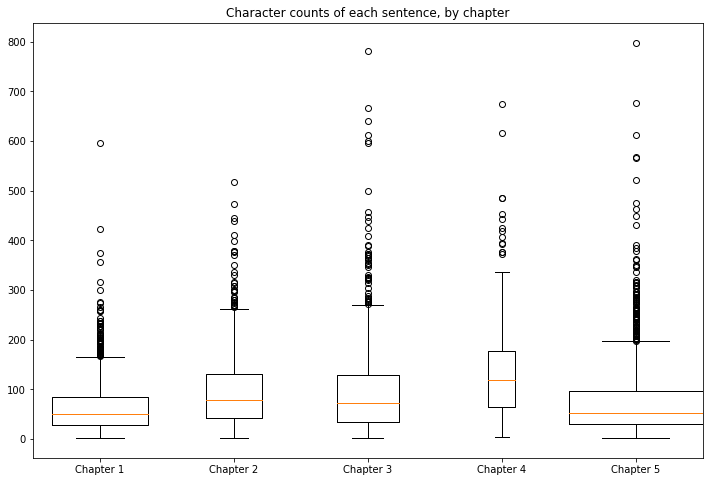

In [59]:
#Box and whisker plots
#Widths of boxes are lengths of chapters in proportion to Chapter 5.
box_widths = [sv_df1['char_count'].shape[0] / sv_df5['char_count'].shape[0],
 sv_df2['char_count'].shape[0] / sv_df5['char_count'].shape[0],
 sv_df3['char_count'].shape[0] / sv_df5['char_count'].shape[0],
 sv_df4['char_count'].shape[0] / sv_df5['char_count'].shape[0],
 sv_df5['char_count'].shape[0] / sv_df5['char_count'].shape[0]
]
#Labels for box and whisker plots
box_labels = ['Chapter 1', 'Chapter 2', 'Chapter 3', 'Chapter 4', 'Chapter 5']

#First box and whisker plot
#Chapter 4 has the longest sentences overall.
#Widths of boxes are lengths of chapters in proportion to Chapter 5.

fig = plt.figure(figsize = (12, 8))
plt.boxplot([sv_df1['char_count'],
             sv_df2['char_count'],
             sv_df3['char_count'],
             sv_df4['char_count'],
             sv_df5['char_count']
            ], 
            labels = box_labels,
            widths = box_widths
           )
plt.title('Character counts of each sentence, by chapter')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Mean token length for each sentence, by chapter')

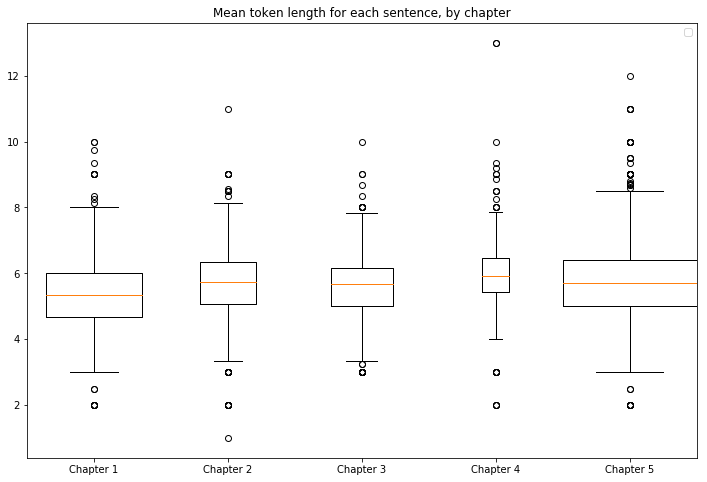

In [60]:
fig = plt.figure(figsize = (12, 8))
plt.boxplot([sv_df1['mean_token_len'],
             sv_df2['mean_token_len'],
             sv_df3['mean_token_len'],
             sv_df4['mean_token_len'],
             sv_df5['mean_token_len']
            ], 
            labels = box_labels,
            widths = box_widths)
plt.legend()
plt.title('Mean token length for each sentence, by chapter')

Text(0.5, 1.0, 'Token count of each sentence, by chapter')

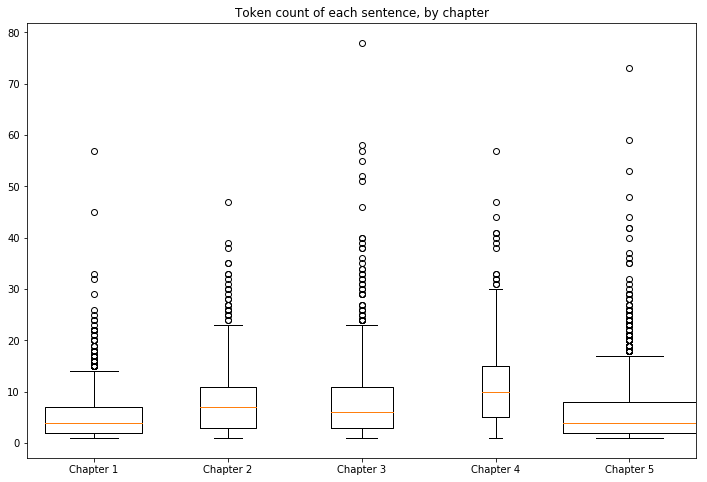

In [61]:
fig = plt.figure(figsize = (12, 8))
plt.boxplot([sv_df1['token_count'],
             sv_df2['token_count'],
             sv_df3['token_count'],
             sv_df4['token_count'],
             sv_df5['token_count']
            ], 
            labels = box_labels,
            widths = box_widths)
plt.title('Token count of each sentence, by chapter')

In [ ]:
#Observations from box plots: Chapter 4 has longer character counts of its sentences
#and longer token counts (lengths of its words)

# Principal component analysis: 300 vectors down to 3
## Sentence 'mean vectors'

In [ ]:
df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0], df5.shape[0]

In [ ]:
#First look at sentence vectors, not normalized
sv_df = sv_df1[['tokens', 'mean_vector', 'label']].append([
                                                    sv_df1[['tokens', 'mean_vector', 'label']], 
                                                    sv_df1[['tokens', 'mean_vector', 'label']],
                                                    sv_df1[['tokens', 'mean_vector', 'label']],
                                                    sv_df1[['tokens', 'mean_vector', 'label']]
                                                    ], ignore_index = True)
#Rename columns to work with pca function
sv_df1.rename({'mean_vector': 'vector', 'tokens': 'token'}, axis = 1, inplace = True)
#Get PCA for this df
df_pca = do_pca(df)


In [ ]:
xyz = [-3, 4, -2.5, 2, -3, 3]
title = 'Sentence vectors by chapter (not normalized)'
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]

#Plot chapters together to see distribution of PCA in 3d
plot_pca(df_pca, plot_list, xyz = xyz, figsize = (14,10), 
          legend = True, title = title)

### Looking at individual plots after spotting a green cluster at azim 60 elev -90

In [ ]:
plot_list = [{1: 'red'}, {2: 'orange'}, {3: 'yellow'}, {4: 'green'}, {5: 'purple'}]
xyz = [-2, 5, -3, 3, -2, 4]

#Draw separate plots for sentence vectors in each chapter
plot_pca(df_pca, plot_list, xyz = xyz)

### Try with PCA = 2?

## Individual  word tokens as vectors

In [ ]:
wv_df1 = word_vec_df(ch1, 1)
wv_df2 = word_vec_df(ch2, 2)
wv_df3 = word_vec_df(ch3, 3)
wv_df4 = word_vec_df(ch4, 4)
wv_df5 = word_vec_df(ch5, 5)
wv_df = wv_df1.append([wv_df2, wv_df3, wv_df4, wv_df5])

In [ ]:
#PRevious ones with old code
wv_df1.shape[0], wv_df1.shape[0], wv_df1.shape[0], wv_df1.shape[0], wv_df1.shape[0]

In [ ]:
wv_df1.shape[0], wv_df2.shape[0], wv_df3.shape[0], wv_df4.shape[0], wv_df5.shape[0]

In [ ]:

byword_pca = do_pca(wv_df)

In [ ]:
#Plot PCA of word vectors together
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]

plot_pca(byword_pca, plot_list, figsize = (12, 8), title = 'PCA of word vectors, not normalized')

In [ ]:
#Show each chapter as its own plot
plot_list = [{1: 'red'}, {2: 'orange'}, {3: 'yellow'}, {4: 'green'}, {5: 'purple'}]

plot_pca(byword_pca, plot_list)

Plotting all word vectors yields basically a big blob.

### How about just the empty vectors?

In [ ]:
empties = wv_df[[True if np.all(row == zeros) else False for row in wv_df['vector']]]

empty_pca = do_pca(empties)
empty_pca.head()

They all get coordinates of 0 0 0

### Will unique words look like anything when plotted?

In [ ]:
zeros = np.zeros(300)

unique1 = appears_in(wv_df, wv_df1, 1)
unique2 = appears_in(wv_df, wv_df2, 2)
unique3 = appears_in(wv_df, wv_df3, 3)
unique4 = appears_in(wv_df, wv_df4, 4)
unique5 = appears_in(wv_df, wv_df5, 5)
uniq1_notna = unique1[[False if np.all(row == zeros) else True for row in unique1['vector']]]
uniq2_notna = unique2[[False if np.all(row == zeros) else True for row in unique2['vector']]]
uniq3_notna = unique3[[False if np.all(row == zeros) else True for row in unique3['vector']]]
uniq4_notna = unique4[[False if np.all(row == zeros) else True for row in unique4['vector']]]
uniq5_notna = unique5[[False if np.all(row == zeros) else True for row in unique5['vector']]]

In [ ]:
# #Tokens unique to chapter 1
# print('unique:', unique1.shape[0], 'unique notna:', uniq1_notna.shape[0])
# print('Total tokens in chapter:', len(wv_df1['token'].values))
# print('\n')
# print('unique:', unique2.shape[0], 'unique notna:', uniq2_notna.shape[0])
# print('Total tokens in chapter:', len(wv_df2['token'].values))
# print('\n')
# print('unique:', unique3.shape[0], 'unique notna:', uniq3_notna.shape[0])
# print('Total tokens in chapter:', len(wv_df3['token'].values))
# print('\n')
# print('unique:', unique4.shape[0], 'unique notna:', uniq4_notna.shape[0])
# print('Total tokens in chapter:', len(wv_df4['token'].values))
# print('\n')
# print('unique:', unique5.shape[0], 'unique notna:', uniq5_notna.shape[0])
# print('Total tokens in chapter:', len(wv_df5['token'].values))

In [ ]:
#PCA for unique vectors, excluding empty vectors
unique_notna = uniq1_notna.append([uniq2_notna, uniq3_notna, uniq4_notna, uniq5_notna])
unique_notna_pca = do_pca(unique_notna)

In [ ]:
#Plot PCA of  unique word vectors together. Excludes NA vectors
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]
xyz = (-4, 2.5, -4, 5, -2, 2.5)
plot_pca(unique_notna_pca, plot_list, xyz = xyz, azim = 30, figsize = (12,10), 
         title = 'PCA of unique word vectors')

In [ ]:
#Plot PCA of unique word vectors separately. Excludes NA vectors
plot_list = [{1: 'red'}, {2: 'orange'}, {3: 'yellow'}, {4: 'green'}, {5: 'purple'}]

plot_pca(unique_notna_pca, plot_list, figsize = (12, 12))

### Amazing discovery re: the blob sticking out

In [ ]:
#What's that blob in the corner?  'PC1' < -2, PC2' > -1, PC3' < -1

#For NON normalized unique tokens
#The blob is all names of people and names of places
xyz = [-10, 1, 1.5, 10, -10, 0]
blob_notna = isolate(unique_notna_pca, xyz = xyz)

In [ ]:
blob_notna.shape[0]

In [ ]:
blob_notna[blob_notna['label'] == 4].head(20)

In [ ]:
prismXYZ = {'names': [-1, 1, 1.5, 4, -2, -1]}
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]
xyz = (-4, 2.5, -4, 5, -2, 2.5)
plot_pca(unique_notna_pca, plot_list, xyz = xyz, azim = 30, alpha = 0.5, figsize = (12,10), 
         prismXYZ = prismXYZ, title = 'PCA of unique word vectors, names in cube')

### Other patterns to draw cubes for:

In [ ]:
#Government, politics, nations, courts
#Very few in chapter 1, a lot in chapter 5
xyz = [0, 3, -4, 0, -1.5, -1]
gov = isolate(unique_notna_pca, xyz)

In [ ]:
prismXYZ = {'gov': [0, 3, -4, 0, -1.5, -1]}
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]
xyz = (-4, 2.5, -4, 5, -2, 2.5)
plot_pca(unique_notna_pca, plot_list, xyz = xyz, azim = 45, alpha = 0.3, figsize = (12,10), 
         prismXYZ = prismXYZ, title = 'PCA of unique word vectors, gov inscribed')

In [ ]:
#A few army words but not as striking as 'gov'
xyz = [0, 1, -4, 0, -1, -0.5]
part = isolate(unique_notna_pca, xyz)

In [ ]:
#Sports!!! Flags, winning, games
xyz = [-1, 0, -4, 0, -1, -0.5]
sports = isolate(unique_notna_pca, xyz)

In [ ]:
prismXYZ = {'sports': [-1, 0, -4, 0, -1, -0.5]}
plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]
xyz = (-4, 2.5, -4, 5, -2, 2.5)
plot_pca(unique_notna_pca, plot_list, xyz = xyz, azim = 45, alpha = 0.3, figsize = (12,10), 
         prismXYZ = prismXYZ, title = 'PCA of unique word vectors, sports!!!')

In [ ]:
#Commercial buildings, waterfront
xyz = [-3, -1, -4, 0, -1, -0.5]
water = isolate(unique_notna_pca, xyz)

In [ ]:
#Stuff: nouns, very few verbs
xyz = [-2, -1, -4, 0, -0.5, -0]
stuff = isolate(unique_notna_pca, xyz)

In [ ]:
#IDEA: k nearest neighbors?
#2667	-2.376713	-0.010858	-0.081842	4	sandy
#2812	-2.579536	-0.781950	-0.204029	4	beach

#A lot of verbs here, present tense not continuous
xyz = [0, 0.5, -4, 0, 0, 0.5]
verbs = isolate(unique_notna_pca, xyz)

In [ ]:
#-ing verbs, but not in chapter 5
xyz = [-0.5, 0, -4, 0, 0, 0.5]
ing = isolate(unique_notna_pca, xyz)

In [ ]:
#Short words?
xyz = [-1, -0.5, -4, 0, 0, 0.5]
short = isolate(unique_notna_pca, xyz)

In [ ]:
#plural nouns
xyz = [-3, -1, -4, 0, 0, 0.5]
plural = isolate(unique_notna_pca, xyz)

In [ ]:
#-ed verbs (past tense)
xyz = [-0.5, 2, -4, 0, 0.5, 1]
ed = isolate(unique_notna_pca, xyz)

In [ ]:
#a lot of short plural nouns and verbs
xyz = [-2.5, -0.5, -4, 0, 0.5, 1]
moreshort = isolate(unique_notna_pca, xyz)

In [ ]:
#fabric and food
xyz = [-3, -2.5, -4, 0, 0.5, 1]
fabric = isolate(unique_notna_pca, xyz)

In [ ]:
#negative feelings
xyz = [0.5, 2, -4, 0, 1, 1.5]
neg = isolate(unique_notna_pca, xyz)

In [ ]:
#oceanfaring verbs, ocean weather
xyz = [-1.5, 0, -4, 0, 1, 1.5]
ocean = isolate(unique_notna_pca, xyz)

In [ ]:
#thigns in a house: food, junk, textures
xyz = [-3.5, -1.5, -4, 0, 1, 1.5]
things = isolate(unique_notna_pca, xyz)

In [ ]:
#More negative ing verbs
xyz = [-1, 2, -4, 0, 1.5, 2]
neging = isolate(unique_notna_pca, xyz)

In [ ]:
#Textures, descriptions of light
xyz = [-2.5, -1, -4, 0, 1.5, 2]
light = isolate(unique_notna_pca, xyz)

In [ ]:
#twisting, coiling
xyz = [-1, 2, -4, 0, 2, 2.5]
twist = isolate(unique_notna_pca, xyz)

# First model: Logistic regression.
## Sentence vectors with principal components as features.
### Plain vanilla model without up- or dowsampling

In [26]:

#sv_df.head()

,token,vector,label
0,"[upon, time, good, time, moocow, coming, along...","[0.16427054, 0.12741734, -0.063235335, -0.1478...",1
1,"[met, nicens, little, boy, named, baby, tuckoo]","[-0.035361428, 0.11802828, -0.28247643, 0.0138...",1
2,"[father, told, story, father, looked, glass, h...","[-0.1338875, -0.10129124, -0.16580924, 0.22228...",1
3,"[baby, tuckoo]","[-0.07225, 0.163415, -0.314415, 0.09163, 0.135...",1
4,"[moocow, came, road, betty, byrne, lived, sold...","[0.07056996, 0.28936455, 0.14651866, -0.130147...",1


In [36]:
#Combine sentence vectors dfs into one
columns = ['token', 'vector', 'label']
sv_df = sv_df1[columns].append([sv_df2[columns], sv_df3[columns], sv_df4[columns], sv_df5[columns]], 
                             ignore_index = True)

#Logistic regressio model
X_train, X_test, y_train, y_test = prepare(sv_df, pca_components = 3,
                                           normalize_vector = True,
                                           features_to_norm = None,
                                           other_features = None)

lr(X_train, X_test, y_train, y_test)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogReg, training set:
              precision    recall  f1-score   support

           1       0.34      0.49      0.40      1065
           2       0.17      0.13      0.15       645
           3       0.31      0.72      0.43       697
           4       0.07      0.04      0.05       294
           5       0.43      0.12      0.18      1483

   micro avg       0.31      0.31      0.31      4184
   macro avg       0.26      0.30      0.24      4184
weighted avg       0.32      0.31      0.26      4184

LogReg, testing set:
              precision    recall  f1-score   support

           1       0.36      0.51      0.43       368
           2       0.18      0.15      0.17       191
           3       0.31      0.71      0.43       225
           4       0.14      0.08      0.10       109
           5       0.47      0.13      0.20       502

   micro avg       0.32      0.32      0.32      1395
   macro avg       0.29      0.32      0.27      1395
weighted avg       0.35      0.32 

### Observations:

Uneven performance from class to class. Unequal sample sizes looks like the biggest problem.

## Second logistic regression model

In [12]:
#First stesp is to adjust sample sizes for the classes
sv_df1.shape[0], sv_df2.shape[0], sv_df3.shape[0], sv_df4.shape[0], sv_df5.shape[0]

(1433, 836, 922, 403, 1985)

In [37]:
#Down-sample chapters 1 and 5
sv1_sample = sv_df1.sample(900, replace = False)
sv5_sample = sv_df5.sample(900, replace = False)
#Up-sample chapter 4 by doubling it
sv4_sample = sv_df4.append(sv_df4, ignore_index = True)

#Combine sentence vectors dfs into one
columns = ['vector', 'label']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_sample[columns], sv5_sample[columns]], 
                             ignore_index = True)

#Logistic regressio model
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 3,
                                           normalize_vector = True,
                                           features_to_norm = None,
                                           other_features = None)

lr(X_train, X_test, y_train, y_test)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogReg, training set:
              precision    recall  f1-score   support

           1       0.32      0.47      0.38       668
           2       0.26      0.20      0.22       659
           3       0.38      0.64      0.47       678
           4       0.28      0.17      0.21       599
           5       0.31      0.14      0.19       669

   micro avg       0.33      0.33      0.33      3273
   macro avg       0.31      0.32      0.30      3273
weighted avg       0.31      0.33      0.30      3273

LogReg, testing set:
              precision    recall  f1-score   support

           1       0.30      0.46      0.36       232
           2       0.19      0.15      0.17       177
           3       0.44      0.63      0.51       244
           4       0.33      0.20      0.25       207
           5       0.28      0.15      0.19       231

   micro avg       0.33      0.33      0.33      1091
   macro avg       0.31      0.32      0.30      1091
weighted avg       0.31      0.33 

### Observations:

Slightly better but still bad. Will try one with the non-vector the other features.

## Third logistic regression model: no vectors, just stats on sentences/tokens

In [138]:
#Combine sentence vectors dfs into one
columns = ['char_count', 'mean_token_len', 'token_count', 'label']
other_features = ['char_count', 'mean_token_len', 'token_count']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_sample[columns], sv5_sample[columns]], 
                             ignore_index = True)

#Logistic regressio model
X_train, X_test, y_train, y_test = prepare(sv_df, 
                                           normalize_vector = False, 
                                           features_to_norm = None, 
                                           other_features = other_features)

y_hat_train, y_hat_test = lr(X_train, X_test, y_train, y_test)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogReg, training set:
              precision    recall  f1-score   support

           1       0.25      0.28      0.27       668
           2       0.25      0.02      0.04       659
           3       0.21      0.16      0.18       678
           4       0.32      0.41      0.36       599
           5       0.22      0.39      0.28       669

   micro avg       0.25      0.25      0.25      3273
   macro avg       0.25      0.25      0.23      3273
weighted avg       0.25      0.25      0.22      3273

LogReg, testing set:
              precision    recall  f1-score   support

           1       0.27      0.29      0.28       232
           2       0.23      0.03      0.05       177
           3       0.27      0.17      0.21       244
           4       0.32      0.37      0.35       207
           5       0.23      0.42      0.29       231

   micro avg       0.26      0.26      0.26      1091
   macro avg       0.26      0.26      0.24      1091
weighted avg       0.26      0.26 

### Observations:
These features may help a model using sentence vectors but wouldn't be good enough on their own.

## Fourth logistic regression model: varying number of principal components

In [141]:
#Combine sentence vectors dfs into one
columns = ['vector', 'label']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_sample[columns], sv5_sample[columns]], 
                             ignore_index = True)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-pac

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-pac

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-pac

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Text(0.5, 1.0, 'Logistic regression with varying principal components')

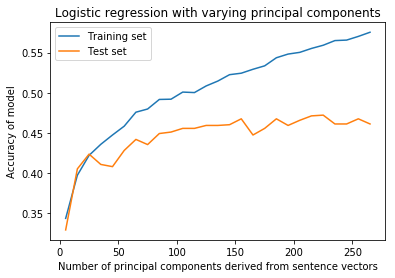

In [143]:
components = np.arange(5, 275, 10)
train_scores = []
test_scores = []

for n in components:
    X_train, X_test, y_train, y_test = prepare(sv_df, pca_components = n,
                                               normalize_vector = True,
                                               features_to_norm = None,
                                               other_features = None)
    train_score, test_score = lr(X_train, X_test, y_train, y_test, report = False)
    #Record scores for each model
    train_scores.append(train_score)
    test_scores.append(test_score)


Text(0.5, 1.0, 'Logistic regression with varying principal components')

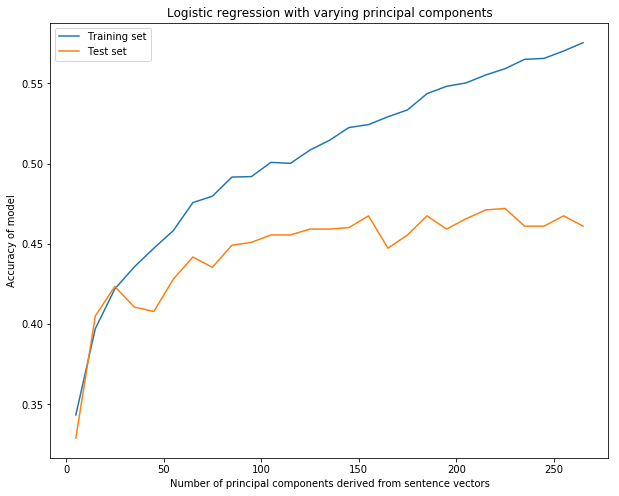

In [148]:
fig = plt.figure(figsize = (10, 8))
plt.plot(components, train_scores, label = 'Training set')
plt.plot(components, test_scores, label = 'Test set')
plt.xlabel('Number of principal components derived from sentence vectors')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Logistic regression with varying principal components')

### Observations: 

The test set accuracy peaks at 155 principal components (half the total vector columns.) I'd like to try adding on some of my engineered features to see if that helps.

## Logistic regression: 155 vector components, plus other engineered features

In [16]:
#Combine sentence vectors dfs into one
columns = ['char_count', 'mean_token_len', 'token_count', 'vector', 'label']
other_features = ['char_count', 'mean_token_len', 'token_count']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_sample[columns], sv5_sample[columns]], 
                             ignore_index = True)

#Logistic regression model
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 155,
                                           normalize_vector = True, 
                                           features_to_norm = None, 
                                           other_features = other_features)

train_score, test_score = lr(X_train, X_test, y_train, y_test)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogReg, training set:
              precision    recall  f1-score   support

           1       0.57      0.59      0.58       668
           2       0.48      0.43      0.45       659
           3       0.61      0.65      0.63       678
           4       0.53      0.56      0.55       599
           5       0.52      0.49      0.50       669

   micro avg       0.54      0.54      0.54      3273
   macro avg       0.54      0.54      0.54      3273
weighted avg       0.54      0.54      0.54      3273

LogReg, testing set:
              precision    recall  f1-score   support

           1       0.52      0.50      0.51       232
           2       0.33      0.41      0.36       177
           3       0.59      0.55      0.57       244
           4       0.43      0.44      0.44       207
           5       0.45      0.40      0.42       231

   micro avg       0.46      0.46      0.46      1091
   macro avg       0.46      0.46      0.46      1091
weighted avg       0.47      0.46 

### Observations:

Not noticeable improvement when adding engineered features.

# Random forests

In [19]:
#Down-sample chapters 1 and 5
sv1_sample = sv_df1.sample(900, replace = False)
sv5_sample = sv_df5.sample(900, replace = False)
#Up-sample chapter by adding half its rows again
sv4_sample = sv_df4.sample(200, replace = False)
sv4_andahalf = sv_df4.append([sv4_sample], ignore_index = True)

#Combine sentence vectors dfs into one
columns = ['vector', 'label']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_andahalf[columns], sv5_sample[columns]], 
                             ignore_index = True)

In [21]:
components = np.arange(5, 275, 10)
train_scores = []
test_scores = []

for n in components:
    X_train, X_test, y_train, y_test = prepare(sv_df,
                                               pca_components = n,
                                               normalize_vector = True, 
                                               features_to_norm = None, 
                                               other_features = None)

    y_hat_train, y_hat_test, train_score, test_score = rf(X_train, X_test, y_train, y_test,
                                report = False)
    train_scores.append(train_score)
    test_scores.append(test_score)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preproc

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preproc

Text(0.5, 1.0, 'Logistic regression with varying principal components')

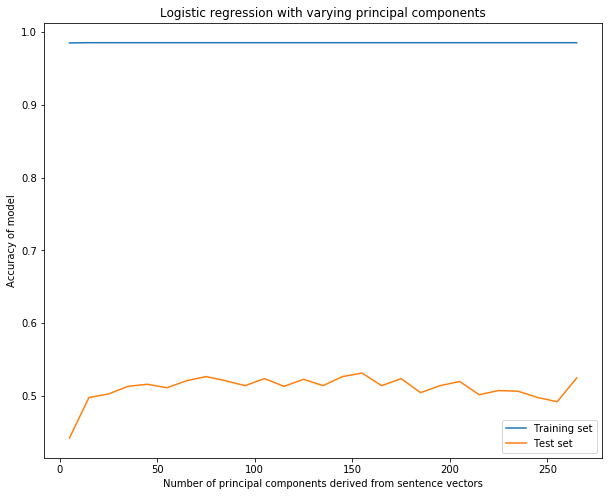

In [22]:
fig = plt.figure(figsize = (10, 8))
plt.plot(components, train_scores, label = 'Training set')
plt.plot(components, test_scores, label = 'Test set')
plt.xlabel('Number of principal components derived from sentence vectors')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Logistic regression with varying principal components')

In [30]:
#Where exactly is the highest testing score?
rf_acc = pd.DataFrame(data = (np.array([components, train_scores, test_scores]).T), 
                      columns = ['components', 'train score', 'test score'])
rf_acc[rf_acc['test score'] > 0.52]

,components,train score,test score
6,65.0,0.985577,0.520653
7,75.0,0.985577,0.526417
8,85.0,0.985577,0.520653
10,105.0,0.985577,0.523535
12,125.0,0.985577,0.522574
14,145.0,0.985577,0.526417
15,155.0,0.985577,0.531220
17,175.0,0.985577,0.523535
26,265.0,0.985577,0.524496


### Observations:

A random forest with no hyperparameter tuning gets highest testing set accuracy at 125 principal components.

How about if my engineered features are added back in?

In [33]:
columns = ['char_count', 'token_count', 'mean_token_len', 'vector', 'label']
sv_df = sv1_sample[columns].append([sv_df2[columns], sv_df3[columns], sv4_andahalf[columns], sv5_sample[columns]], 
                             ignore_index = True)

#Same thing but engineered features added in 
components = np.arange(5, 275, 20)
train_scores = []
test_scores = []

for n in components:
    X_train, X_test, y_train, y_test = prepare(sv_df,
                                               pca_components = n,
                                               normalize_vector = True, 
                                               features_to_norm = None, 
                                               other_features = ['char_count',
                                                                 'token_count',
                                                                'mean_token_len'])

    y_hat_train, y_hat_test, train_score, test_score = rf(X_train, X_test, y_train, y_test,
                                report = False)
    train_scores.append(train_score)
    test_scores.append(test_score)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preproc

Text(0.5, 1.0, 'Logistic regression with varying principal components')

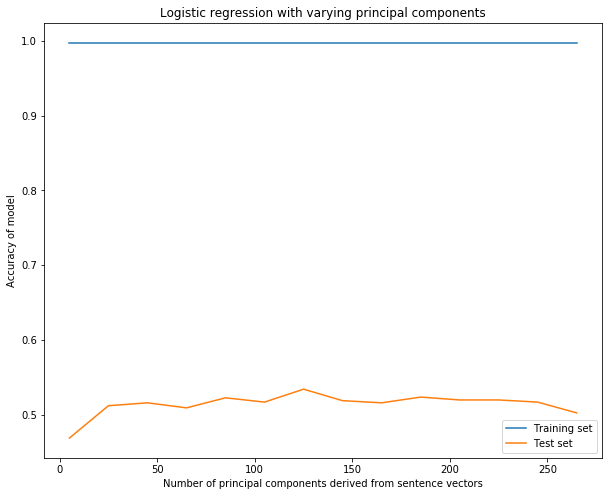

In [34]:
fig = plt.figure(figsize = (10, 8))
plt.plot(components, train_scores, label = 'Training set')
plt.plot(components, test_scores, label = 'Test set')
plt.xlabel('Number of principal components derived from sentence vectors')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Logistic regression with varying principal components')

In [35]:
#Where exactly is the highest testing score?
rf_acc = pd.DataFrame(data = (np.array([components, train_scores, test_scores]).T), 
                      columns = ['components', 'train score', 'test score'])
rf_acc[rf_acc['test score'] > 0.52]

,components,train score,test score
4,85.0,0.997436,0.522574
6,125.0,0.997436,0.534102
9,185.0,0.997436,0.523535


### Observations:

A random forest with 125 principal components and the engineered features gets 53% accuracy on the testing set.

### Hyperparameter tuning: Estimators

In [36]:
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 125,
                                           normalize_vector = True, 
                                           features_to_norm = None, 
                                           other_features = ['char_count',
                                                             'token_count',
                                                            'mean_token_len'])

estimators = np.arange(5, 200, 20)
train_scores = []
test_scores = []

for n in estimators:
    y_hat_train, y_hat_test, train_score, test_score = rf(X_train, X_test, y_train, y_test,
                                 n_estimators = n,
                                 report = False)
    train_scores.append(train_score)
    test_scores.append(test_score)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Text(0.5, 1.0, 'Random forest')

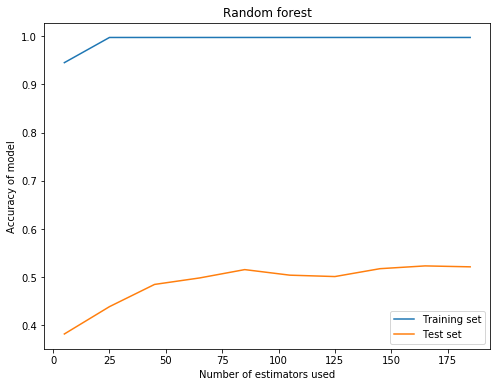

In [37]:
fig = plt.figure(figsize = (8, 6))
plt.plot(estimators, train_scores, label = 'Training set')
plt.plot(estimators, test_scores, label = 'Test set')
plt.xlabel('Number of estimators used')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Random forest')

In [39]:
#Where exactly is the highest testing score?
rf_acc = pd.DataFrame(data = (np.array([estimators, train_scores, test_scores]).T), 
                      columns = ['estimators', 'train score', 'test score'])
rf_acc[rf_acc['test score'] > 0.51]

,estimators,train score,test score
4,85.0,0.997436,0.515850
7,145.0,0.997436,0.517771
8,165.0,0.997436,0.523535
9,185.0,0.997436,0.521614


### Observations: 
85 looks like the best number of estimators to use.

In [41]:
y_hat_train, y_hat_test, train_score, test_score = rf(X_train, X_test, y_train, y_test,
                                 n_estimators = 85,
                                 report = True)

Random forest, training set:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       664
           2       1.00      1.00      1.00       651
           3       0.99      1.00      1.00       686
           4       1.00      1.00      1.00       466
           5       1.00      1.00      1.00       653

   micro avg       1.00      1.00      1.00      3120
   macro avg       1.00      1.00      1.00      3120
weighted avg       1.00      1.00      1.00      3120

Random forest, testing set:
              precision    recall  f1-score   support

           1       0.45      0.53      0.48       236
           2       0.36      0.44      0.40       185
           3       0.60      0.61      0.60       236
           4       0.73      0.61      0.66       137
           5       0.44      0.34      0.38       247

   micro avg       0.49      0.49      0.49      1041
   macro avg       0.52      0.50      0.51      1041
weighted avg       0


What about max depth?

### Hyperparameter tuning: max depth

In [43]:
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 125,
                                           normalize_vector = True, 
                                           features_to_norm = None, 
                                           other_features = ['char_count',
                                                             'token_count',
                                                            'mean_token_len'])

depths = np.arange(8, 30, 2)
train_scores = []
test_scores = []

for n in depths:
    y_hat_train, y_hat_test, train_score, test_score = rf(X_train, X_test, y_train, y_test,
                                 n_estimators = 85,
                                 max_depth = n,
                                 report = False)
    train_scores.append(train_score)
    test_scores.append(test_score)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Text(0.5, 1.0, 'Random forest')

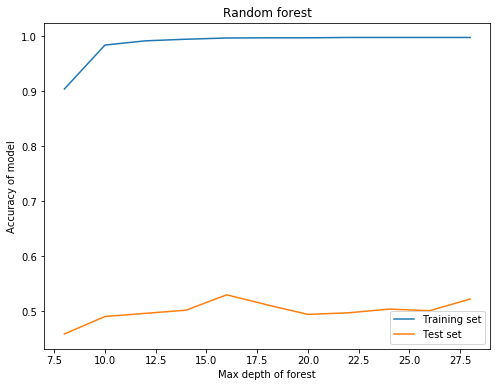

In [44]:
fig = plt.figure(figsize = (8, 6))
plt.plot(depths, train_scores, label = 'Training set')
plt.plot(depths, test_scores, label = 'Test set')
plt.xlabel('Max depth of forest')
plt.ylabel('Accuracy of model')
plt.legend()
plt.title('Random forest')

In [45]:
#Where exactly is the highest testing score?
rf_acc = pd.DataFrame(data = (np.array([depths, train_scores, test_scores]).T), 
                      columns = ['depth', 'train score', 'test score'])
rf_acc[rf_acc['test score'] > 0.51]

,depth,train score,test score
4,16.0,0.996474,0.530259
5,18.0,0.996795,0.512008
10,28.0,0.997436,0.522574


### Observations:

Highest accuracy at depth of 16.

In [46]:
#Final random forest model
X_train, X_test, y_train, y_test = prepare(sv_df,
                                           pca_components = 125,
                                           normalize_vector = True, 
                                           features_to_norm = None, 
                                           other_features = ['char_count',
                                                             'token_count',
                                                            'mean_token_len'])

y_hat_train, y_hat_test, train_score, test_score = rf(
                            X_train, X_test, y_train, y_test,
                             n_estimators = 85,
                             max_depth = 16,
                             report = True)

C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Stee\Anaconda3good\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Random forest, training set:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       664
           2       1.00      1.00      1.00       651
           3       0.99      1.00      1.00       686
           4       1.00      1.00      1.00       466
           5       1.00      0.99      1.00       653

   micro avg       1.00      1.00      1.00      3120
   macro avg       1.00      1.00      1.00      3120
weighted avg       1.00      1.00      1.00      3120

Random forest, testing set:
              precision    recall  f1-score   support

           1       0.50      0.54      0.52       236
           2       0.39      0.48      0.43       185
           3       0.59      0.65      0.62       236
           4       0.77      0.61      0.68       137
           5       0.49      0.37      0.42       247

   micro avg       0.52      0.52      0.52      1041
   macro avg       0.55      0.53      0.53      1041
weighted avg       0

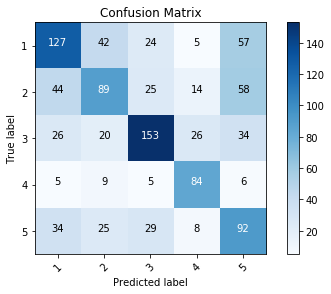

In [47]:
# CONFUSION MATRIX
classes = ['1', '2', '3', '4', '5']
#Create a confusion matrix with the training results
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#Create a confusion matrix with the test results
conf_matrix_test = confusion_matrix(y_hat_test, y_test)
plot_conf_matrix(conf_matrix_test, classes, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues)

### Observations:

With an ensemble classifier we can achieve 53% accuracy in predicting test data.

# Custom Functions

In [2]:
def rf(X_train, X_test, y_train, y_testl,
       n_estimators=175,
       max_depth = 30,
       report = True):
    
    #Instantiate model
    forest = RandomForestClassifier(n_estimators = n_estimators, 
                                max_depth = max_depth, 
                                bootstrap = True
                               )
    
    # Fit the training data to the model
    forest.fit(X_train, y_train)

    # Generate predicted values for y to compare to real values
    y_hat_train = forest.predict(X_train)
    #Now generate predicted values for the test data to compare
    y_hat_test = forest.predict(X_test)
    
    #Print scores
    target_names = [str(c) for c in forest.classes_]
    if report:
        print('Random forest, training set:')
        print(classification_report(y_train, y_hat_train, target_names = target_names))
        print('Random forest, testing set:')
        print(classification_report(y_test, y_hat_test, target_names = target_names))
    
    return y_hat_train, y_hat_test, forest.score(X_train, y_train), \
            forest.score(X_test, y_test)

In [3]:
def prepare(df,
            pca_components = None,
            normalize_vector = False,
            features_to_norm = None, 
            other_features = None,
           ):
    '''
    Pipeline for preparing data for modeling.
    Parameters:
    df (pd.DataFrame) Sentence vector DataFrame.
    pca_components (int) Number of principal components to extract from vectors.
    features_to_norm (list) Features (other than 'vector') to include in the model.
    other_features (list) Features to include without normalizing.

    
    '''
    
    #2 Use PCA to get a few columns from the hundreds of vector columns
    if pca_components:
        #1 Turn vector into columns
        vector_cols = vec_to_col(df['vector'].values)
        
        pca = PCA(n_components = pca_components)
            #Returns an array with as many columns as you chose components
        if normalize_vector:
            principalComponents = pca.fit_transform(StandardScaler().fit_transform(vector_cols))
        else:
            principalComponents = pca.fit_transform(vector_cols)   
            #Create a new DataFrame for principal components 
        columns = ['PC' + str(i + 1) for i in range(principalComponents.shape[1])]
        pca_df = pd.DataFrame(data = principalComponents, columns = columns)
        # Combine features into df
        X = copy.deepcopy(pca_df)
    else:
        X = pd.DataFrame()

        #If features other than the vectors are to be normalized
    if features_to_norm:
        normed = StandardScaler().fit_transform(df[features_to_norm])
        normed_df = pd.DataFrame(data = normed, columns = features_to_norm)
        X = pd.concat([X, normed_df], axis = 1)
    
        #If any other features, not normalized, are to be included
    if other_features:
        X = pd.concat([X, df[other_features]], axis = 1)
    
    #5 Get target
    y = df['label']
    
    #[OPTIONAL] Adjust sizes of chapters  ####
    
    #6 Do train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
    
    return X_train, X_test, y_train, y_test

def lr(X_train, X_test, y_train, y_testl,
      report = True):
    
    #Instantiate model
    logreg = LogisticRegression(fit_intercept=False, C=1e16)
    
    # Fit the training data to the model
    logreg.fit(X_train, y_train)

    # Generate predicted values for y to compare to real values
    y_hat_train = logreg.predict(X_train)
    #Now generate predicted values for the test data to compare
    y_hat_test = logreg.predict(X_test)
    
    #Print scores
    target_names = [str(c) for c in logreg.classes_]
    if report:
        print('LogReg, training set:')
        print(classification_report(y_train, y_hat_train, target_names = target_names))
        print('LogReg, testing set:')
        print(classification_report(y_test, y_hat_test, target_names = target_names))
    
    return logreg.score(X_train, y_train), logreg.score(X_test, y_test)

In [4]:
def stop(word):
    '''
    Parameters:
    word (str)
    '''
    stop_list = stopwords.words('english')
    stop_list += list(string.punctuation)
    stop_list += ['could', 'like', 'one', 'said', 'would', '\'s', '\'ll']
    
    if word.isalpha():
        if word.lower() not in stop_list:
            return word.lower()  

# FOR CONSTRUCTING DFS OF VECTORS ###########################
def word_vec_df(chapter, label):
    '''
    Constructs a df to track words in a chapter, each word's token,
    and each token's vector.
    Parameters:
    chapter (spacy.tokens.doc.Doc) The text of a chapter.
    label (int) The chapter number.
    Returns:
    df (pd.DataFrame)
    '''
   
    #Token for each word in the text that survives stoppage  
    #Only need unique tokens, so we take the set
    tokens = list(set([stop(t) for t in word_tokenize(chapter.text) if stop(t)]))
    
    #Vector for each token
    vectors = [nlp.vocab[t].vector for t in tokens]
    
    #Instantiate new df
    df = pd.DataFrame()
    #Build df columns from above lists
    df['token'] = tokens
    df['vector'] = vectors
    df['label'] = label
    
    return df

def sent_vec_df(chapter, labels):
    '''
    Consructs a df to track a chapter's sentences, each sentence's tokens,
    some stats on the tokens, each token's vector, and the 
    'mean vector' for each sentence's vectors.
   
    Parameters:
    chapter (spacy.tokens.doc.Doc) The text of a chapter.
    label (int) The chapter number.
    
    Returns:
    df (pd.DataFrame)
    '''
    #Turn spacy doc into lists of sentences as strings
    sentences = [str(s) for s in list(chapter.sents)]
    
    #Number of characters in each sentence
    char_counts = [len(s) for s in sentences]
   
    #The tokens for each sentence
    tokenized_sentences = [[stop(t) for t in word_tokenize(sentence) if stop(t)] \
                               for sentence in sentences]
    
    #Average length of token in each sentence
    mean_token_len = [np.mean([len(t) for t in tokens]
                             ) for tokens in tokenized_sentences]
    #Number of tokens in each sentence
    #(Those with 0 will be dropped later)
    token_counts = [len(t) for t in tokenized_sentences]
                               
    #The vector for each token
    vectorized_tokens = [[nlp.vocab[t].vector for t in tokenized_sent] \
                             for tokenized_sent in tokenized_sentences]
    
    #The 'mean vector' for each sentence's vectors
    #(Each mean vector is itself a 300-dimension vector like the originals)
    mean_vectors = [np.mean([v for v in vector_list], 
                           axis = 0
                          ) for vector_list in vectorized_tokens]
    
    #Instantiate new df
    df = pd.DataFrame()
    #Build df columns from above lists
    df['sentence'] = sentences
    df['char_count'] = char_counts
    df['token'] = tokenized_sentences
    df['mean_token_len'] = mean_token_len
    df['token_count'] = token_counts
    df['vectors'] = vectorized_tokens
    df['vector'] = mean_vectors
    df['label'] = labels
    
    #Drop rows which don't have any tokens
    df = df[df['token_count'] != 0]
    
    return df

def appears_in(text, chap, label):
    '''
    Gets words that are unique to a chapter. Checks a chapter's words
    against the words in the rest of the text.
   
    Parameters:
    text (pd.DataFrame) The full text. (Requires either a sv_df or wv_df.)
    chap (pd.DataFrame) Just this chapter.
    label (int) This chapter's number.
    
    Return:
    df (pd.DataFrame)
    '''
    #List of words from other chapters
    other_chapters = text[text['label'] != label]['token'].values
    
    #List of words from this chapter
    this_chapter = chap['token'].values
    
    #List of bools for words unique to this chapter
    unique_words = [True if v not in other_chapters else False \
                     for v in this_chapter]
    df = chap[unique_words]
    return df

# PCA functions ##############################################################
#vec_to_col
def vec_to_col(vector_arr):
    '''
    Turns an array of vectors into columns for each vector.
    Use df['vector'].values to pass in the array of vectors.
    It gets turned into a 300-wide array with as many rows as rows in the df.
    '''
    #Make new 2d array
    data = np.array(list(vector_arr))
    
    #Make list of column names
    #Assumes all vectors have same dimensions
    columns = [str(i) for i in range(data.shape[1])]
    
    #Instantiate new df to hold vector dimensions as columns
    vector_cols = pd.DataFrame(data = data, columns = columns)

    return vector_cols
#def get_x_y(df):
    

def do_pca(df, veclen = 300, normalize = False, components = 3):    
    '''
    
    '''
    #Turn vectors into columns.
    vector_cols = vec_to_col(df['vector'].values)
    
    #Attach vector columns to dataframe
    df = pd.concat([df, vector_cols], axis = 1)
    
    #Get features and target.
    features = df.drop(['token', 'vector', 'label'], axis = 1, inplace = False)
    target = df['label']
    
    if normalize:
        X = StandardScaler().fit_transform(features)
    else:
        X = features
        
    #Get principal components from features with PCA object
    pca = PCA(n_components = components)
    principalComponents = pca.fit_transform(X)

    # Create a new DataFrame for principal components 
    columns = ['PC' + str(i + 1) for i in range(principalComponents.shape[1])]
    pca_df = pd.DataFrame(data = principalComponents, columns = columns)
   
    #Add other features back
    pca_df['label'] = target.values
    pca_df['token'] = df['token'].values
    pca_df['vector'] = df['vector'].values
    
    return pca_df

def get_xyz(xyz):
    '''
    Helper function for plotting.
    Parameters:
    xyz (list) List with 6 integers.
    Returns:
    6 integers in variables
    '''
    xmin, xmax, ymin, ymax, zmin, zmax = xyz[0], xyz[1], xyz[2], xyz[3], xyz[4], xyz[5]
    return xmin, xmax, ymin, ymax, zmin, zmax

def plot_pca(df, plot_list, 
             xyz = None,
             figsize = (12, 14),
             azim = 60, 
             elev = 30,
             alpha = None,
             prismXYZ = None,
             legend = False,
             title = None):
    '''
    Draws a flexible figure of subplots, with as many as are listed
    in the plot list of dictionaries. Each subplot can have one or more
    scatters drawn together depending on how many key/val pairs are in
    the dict.
    Parameters:
    df (pd.DataFrame) Needs columns for 'PC1', 'PC2', and 'PC3.'
    plot_list (list) List of dictionaries. Each dict is a subplot with as many 
    scatters as there are key/val pairs in the dict. E.g. for one plot with one scatter,
    use a list with 1 dict with 1 key/val pair.
    xyz (list) List of limits for the three dimensions.
    figsize (tuple) Size of figure.
    azim (int): Horizontal view of the plot.
    elev (int): Vertical view of the plot.
    alpha (float): Value between 0 and 1. Transparency of scatters.
    prismXYZ (dict): Dict with prism names as keys and dimension lists as values.
    legend (bool): True if a legend should be drawn.
    title (str): Title of plot (only really if just one plot being shown.)
    
    Returns: 
    Draws a plot.
    '''
    #Get xyz limits for the plots.
    if xyz:
        xmin, xmax, ymin, ymax, zmin, zmax = get_xyz(xyz)
    
    #Get right number of rows whether length is even or odd.
    #Needed this instead of just rounding because of 'banker's rounding.'
    rows = (len(plot_list) // 2) + (len(plot_list) % 2)

    #Set columns. 1 if 1 plot, else 2.
    if len(plot_list) == 1:
        cols = 1
    else:
        cols = 2
    #Draw figure to hold all plots
    fig = plt.figure(figsize = figsize)    
    
    #Draw a subplot for each dict in the plot list.
    #If just one subplot should be drawn, put just one dict in the list.
    #The plot will fill the figure.
    for i in range(len(plot_list)): 
        ax = fig.add_subplot(rows, cols, (i + 1), 
                             projection='3d', 
                             azim = azim, 
                             elev = elev)
        if xyz: 
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            ax.set_zlim(zmin, zmax)
        
        #Draw each scatter within a subplot. 1 for each key/val pair in the dict.
        #(Allows for each subplot to show one or more scatters.)
        #together.
        for label, color in  plot_list[i].items():
            #Pull the data from the df corresponding to each label
            pca = df[df['label'] == label]
            #Draw a scatter for the data from each label
            ax.scatter(xs = pca['PC1'], 
                       ys = pca['PC2'], 
                       zs = pca['PC3'],
                       c = color,
                       alpha = alpha,
                       label = ('Chapter ' + str(label)))
        
        #Draw prisms
        if prismXYZ:
            #Draw each prism in list
            #Leaving prismXYZ as a dict for the moment in case I want to use labels
            for label, xyz in prismXYZ.items():
                draw_prism(xyz, 'black')
        
            
        #Label axes for each subplot
        ax.set_xlabel('x, PC1')
        ax.set_ylabel('y, PC2')
        ax.set_zlabel('z, PC3')
        
        #Set legend for each subplot
        if legend:
            plt.legend()
        #Set title for each subplot
        if not title:
            plt.title('Chapters: ' + str(list(plot_list[i].keys())))
        else:
            plt.title(title)
    plt.show()
    
def isolate(df, xyz):
    '''
    Parameters:
    df (pd.DataFrame) Needs a 'label' column to work. Needs PC1, 2, and 3 columns.
    xyz (list) List of limits for PC1, 2, and 3.
   
    Returns:
    blob_df (pd.DataFrame) Section of the pca_df within the 
    spatial limits set by the parameters. The 'blob' within 
    a 'cube' on a 3d plot.
    '''
    xmin, xmax, ymin, ymax, zmin, zmax = get_xyz(xyz)
    
    blob = df[
                    ((df['PC1'] > xmin) & (df['PC1'] < xmax )) & \
                    ((df['PC2'] > ymin) & (df['PC2'] < ymax )) & \
                    ((df['PC3'] > zmin) & (df['PC3'] < zmax ))
                ]
    return blob

def draw_prism(xyz, color):
    '''
    When called within plot_pca, draws a prism in a 3d plot.
    Works well with isolate() to visualize the isolated tokens.
    '''
    #1 .   2 .   3 .   4 .   5 .  6
    xmin, xmax, ymin, ymax, zmin, zmax = get_xyz(xyz)
    c = color
    plt.plot([], [], [], color = c)
    
    kwargs = {'linewidth': 4}
    
    #I tried a lot of ways of consolidating these loops further
    #but decided to move on.
    #x limits at zmin
    for x in [xmin, xmax]:
        plt.plot([x, x], [ymin, ymax], [zmin, zmin], color = c, **kwargs)

    #y limiits at zmin
    for y in [ymin, ymax]:
        plt.plot([xmin, xmax], [y, y], [zmin, zmin], color = c, **kwargs)

    #x limits at zmax
    for x in [xmin, xmax]:
        plt.plot([x, x,], [ymin, ymax,], [zmax, zmax], color = c, **kwargs)

    #y limits at zmax
    for y in [ymin, ymax]:
        plt.plot([xmin, xmax], [y, y], [zmax, zmax], color = c, **kwargs)

    #z limits
    for x in [xmin, xmax]:
        for y in [ymin, ymax]:
            plt.plot([x, x], [y, y], [zmin, zmax], color = c, **kwargs)
            
    #Draw label
    #ax.text(xmax, ymax, zmin, s = label)
##############################################################



In [5]:
def plot_conf_matrix(cm, classes, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues):

    '''
    Draws a heat map to show true positives, false positives, &c
    for given predicted y values vs actual y values.
    Parameters:
    cm (np.array) The confusion matrix for a model's predictions.
    class (list) Names of classes/categories.
    Returns:
    Visualized heat map of the confusion matrix.
    '''

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#TEST FOR MULTIPLE CUBES IN ONE PLOT

# #twisting
# names = [-1, 1, 1.5, 4, -2, -1]
# twisting = [-1, 2, -4, 0, 2, 2.5]
# #Sports!!! Flags, winning, games
# sports = [-1, 0, -4, 0, -1, -0.5]
# prismXYZ = {'names': names, 
#             'twisting': twisting, 
#             'sports': sports}
# #TEST PRISM for twisting curling
# plot_list = [{1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple'}]
# xyz = (-4, 2.5, -4, 5, -2, 2.5)
# plot_pca(unique_notna_pca, plot_list, xyz = xyz, azim = 30, alpha = 0.7, figsize = (12,10),
#          prismXYZ = prismXYZ,
#          title = 'PCA of unique word vectors with prism')

In [ ]:
#Functions from Parrish

# def subtractv(coord1, coord2):
#     return [c1 - c2 for c1, c2 in zip(coord1, coord2)]

# def addv(coord1, coord2):
#     return [c1 + c2 for c1, c2 in zip(coord1, coord2)]

# def meanv(coords):
#     # assumes every item in coords has same length as item 0
#     sumv = [0] * len(coords[0])
#     for item in coords:
#         for i in range(len(item)):
#             sumv[i] += item[i]
#     mean = [0] * len(sumv)
#     for i in range(len(sumv)):
#         mean[i] = float(sumv[i]) / len(coords)
#     return mean


# #Convenience function
# def vec(s):
#     return nlp.vocab[s].vector

# # cosine similarity
# def cosine(v1, v2):
#     if norm(v1) > 0 and norm(v2) > 0:
#         return dot(v1, v2) / (norm(v1) * norm(v2))
#     else:
#         return 0.0
    
# def spacy_closest(token_list, vec_to_check, n=10):
#     return sorted(token_list,
#                   key=lambda x: cosine(vec_to_check, vec(x)),
#                   reverse=True)[:n]

# def sentvec(s):
#     sent = nlp(s)
#     return meanv([w.vector for w in sent])

# def spacy_closest_sent(space, input_str, n=10):
#     input_vec = sentvec(input_str)
#     return sorted(space,
#                   key=lambda x: cosine(np.mean([w.vector for w in x], axis=0), input_vec),
#                   reverse=True)[:n]

#Tinkering from Parrish:

# cosine(vec('dog'), vec('puppy')) > cosine(vec('trousers'), vec('pants'))
# spacy_closest(tokens5, vec("pie"))
# blue_to_sky = subtractv(vec("blue"), vec("sky"))
# spacy_closest(tokens5, addv(blue_to_sky, vec("grass")))

#spacy_closest(ch1_nlp_tokens, vec(ch1_nlp_tokens[0]))

#sents1 = list(ch3.sents)
#for sent in spacy_closest_sent(sents1, "I went to church this morning."):
#    print(sent.text)
#    print("---")

#From Parrish
#nlp.vocab['cheese'].vector

In [ ]:
# Insight workflow
### Data cleaning:
- tokenize
- remove non-alphanumeric
- to lower case
- combine words with similar spellings
- lemmatize?

### Words into numbers
- bag words [0 0 0 0 0 1 0 0 ]